In [1]:
import os
import shutil
import pandas as pd

# Path to your training folder
training_folder = 'training'

# Path to your CSV file
csv_file = 'UrbanSound8K.csv'

# Read CSV file
df = pd.read_csv(csv_file)

# Group WAV file names by class name
grouped = df.groupby('class')['slice_file_name'].apply(list).to_dict()

# Create folders for each class
for classname in grouped.keys():
    class_folder = os.path.join(training_folder, classname)
    os.makedirs(class_folder, exist_ok=True)

    # Move WAV files to class folder
    for fold_num in range(1, 11):  # Assuming 10 folds
        fold_folder = os.path.join(training_folder, 'fold{}'.format(fold_num))
        for wav_filename in grouped[classname]:
            source_path = os.path.join(fold_folder, wav_filename)
            dest_path = os.path.join(class_folder, wav_filename)
            if os.path.exists(source_path):
                shutil.move(source_path, dest_path)

In [33]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-06-10 14:16:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-10 14:16:29 (44.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
for fold_num in range(1, 11):  # Assuming 10 folds
        fold_folder = os.path.join(training_folder, 'fold{}'.format(fold_num))
        os.rmdir(fold_folder)

FileNotFoundError: [Errno 2] No such file or directory: 'training/fold1'

In [5]:
print(df.head())

      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  


In [5]:
data_dir = "training/"
classes=pd.unique(df["class"])
print(classes)

['dog_bark' 'children_playing' 'car_horn' 'air_conditioner' 'street_music'
 'gun_shot' 'siren' 'engine_idling' 'jackhammer' 'drilling']


In [6]:
import librosa
import numpy as np
import tensorflow as tf
from sklearn import model_selection
def load_and_preprocess_data(data_dir, classes, target_shape=(128, 128)):
    data=[]
    labels=[]
    target_sr = 44100

    for i, classname in enumerate(classes):
        class_dir = os.path.join(data_dir, str(classname))
        for filename in os.listdir(class_dir):
            if filename.endswith(".wav"):
                filepath = os.path.join(class_dir, filename)
                audio_data, sampling_rate = librosa.load(filepath, sr=None)
                audio_data = librosa.resample(audio_data, orig_sr=sampling_rate, target_sr=target_sr)
                if (audio_data.shape[0] > ((target_sr//1000) * 4000)):
                    audio_data = audio_data[:((target_sr//1000) * 4000)]
                elif (audio_data.shape[0] < ((target_sr//1000) * 4000)):
                    audio_data = librosa.util.pad_center(data=audio_data, size=(target_sr//1000) * 4000, axis=0)
                
                mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=target_sr, n_mels=64, n_fft=1024, hop_length=None)
                mel_spec = tf.image.resize(np.expand_dims(mel_spec, axis=-1), target_shape)
                data.append(mel_spec)
                labels.append(i)
    return np.array(data), np.array(labels)


In [7]:

data, labels = load_and_preprocess_data(data_dir, classes)
labels = tf.keras.utils.to_categorical(labels, num_classes=len(classes))
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, labels, test_size=0.2, random_state=42)


2024-06-10 14:26:54.952113: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-06-10 14:26:54.952132: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-10 14:26:54.952138: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-10 14:26:54.952152: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-10 14:26:54.952163: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:

X_train, X_test, y_train, y_test = model_selection.train_test_split(data, labels, test_size=0.2, random_state=42)


In [9]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

6985 1747 6985 1747


In [39]:
# Create model CNN architecture
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
def create_model(X_train):
    input_shape = X_train[0].shape
    input_layer = Input(shape=input_shape)
    x = Conv2D(64, (3,3), activation="relu")(input_layer)
    x = Conv2D(32, (3,3), activation = "relu")(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(32, (3,3), activation="relu")(x)
    x = Conv2D(16, (3,3), activation="relu")(x)
    x = MaxPooling2D(2)(x)
    x = Flatten()(x)
    x = Dense(64, activation="relu")(x)
    ouput_layer = Dense(len(classes), activation="softmax")(x)
    model = Model(input_layer, ouput_layer)
    return model

In [40]:
# Compile it with callbacks
from helper_functions import create_tensorboard_callback, compare_historys, plot_loss_curves

stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience = 5,
    restore_best_weights=True
)

checkpoint_path = "model_checkpoints/model1.model.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    save_best_only = True
)

learning_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=10,
    min_lr = 0.000001
)

model1 = create_model(X_train)
model1.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])


In [41]:
history1 = model1.fit(X_train,
                      y_train,
                      epochs=100,
                      validation_data=(X_test, y_test),
                      callbacks=[create_tensorboard_callback(dir_name="tensorboard_histories",
                                                             experiment_name="model_1"),
                                 learning_callback,
                                 stop_callback,
                                 checkpoint_callback])

Saving TensorBoard log files to: tensorboard_histories/model_1/20240610-145244
Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.3029 - loss: 2.0291 - val_accuracy: 0.4677 - val_loss: 1.5377 - learning_rate: 0.0010
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.5635 - loss: 1.2717 - val_accuracy: 0.6371 - val_loss: 1.2313 - learning_rate: 0.0010
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.6993 - loss: 0.9100 - val_accuracy: 0.6978 - val_loss: 1.1008 - learning_rate: 0.0010
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.7706 - loss: 0.6849 - val_accuracy: 0.7184 - val_loss: 1.0074 - learning_rate: 0.0010
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.8377 - loss: 0.4862 - val_accuracy: 0.7527 - val_loss: 1.1168 - learning_rate: 0.0010
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.8867 - loss: 0.3588 - val_accuracy: 0.7355 - val_loss: 1.1270 - learning_rate: 0.0

In [42]:
model1_accuracy = model1.evaluate(X_test, y_test)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7227 - loss: 1.0457


This is not great, so lets look at some of the loss curves

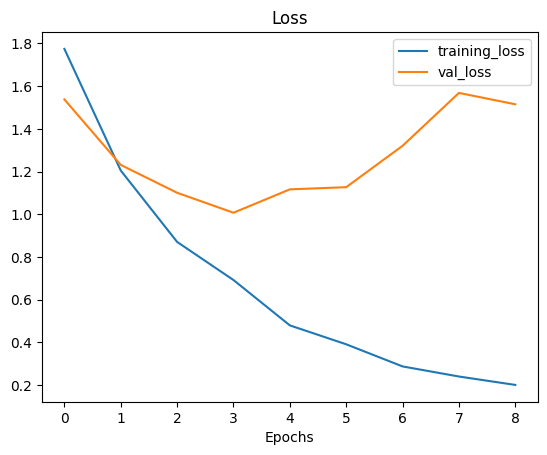

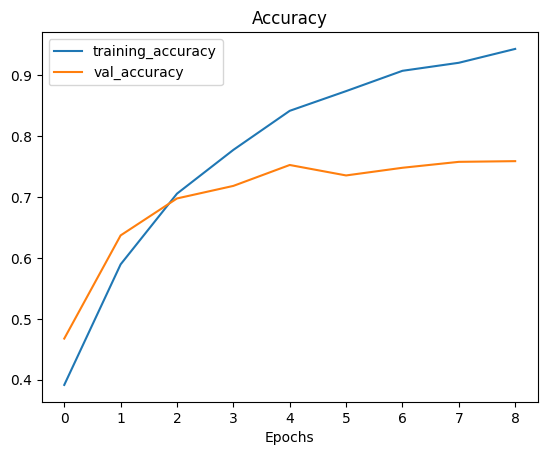

In [43]:
plot_loss_curves(history1)

We can see some sever overfitting, lets try and add dropout layers and see if that helps

In [44]:
input_shape = X_train[0].shape
input_layer = Input(shape=input_shape)
x = Conv2D(64, (3,3), activation="relu")(input_layer)
x = tf.keras.layers.Dropout(0.3)(x)
x = Conv2D(32, (3,3), activation = "relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = MaxPooling2D(2)(x)
x = Conv2D(32, (3,3), activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = Conv2D(16, (3,3), activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = MaxPooling2D(2)(x)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
ouput_layer = Dense(len(classes), activation="softmax")(x)
model2 = Model(input_layer, ouput_layer)

In [45]:
model2.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [46]:
stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience = 10,
    restore_best_weights=True
)

checkpoint_path = "model_checkpoints/model2.model.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    save_best_only = True
)

learning_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    min_lr = 0.000001
)

history2 = model2.fit(X_train,
                      y_train,
                      epochs=100,
                      validation_data=(X_test, y_test),
                      callbacks=[create_tensorboard_callback(dir_name="tensorboard_histories",
                                                             experiment_name="model_2"),
                                 learning_callback,
                                 stop_callback,
                                 checkpoint_callback])


Saving TensorBoard log files to: tensorboard_histories/model_2/20240610-145442
Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.2831 - loss: 2.0689 - val_accuracy: 0.4619 - val_loss: 1.6234 - learning_rate: 0.0010
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.5555 - loss: 1.3241 - val_accuracy: 0.5799 - val_loss: 1.3318 - learning_rate: 0.0010
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.6498 - loss: 1.0088 - val_accuracy: 0.6840 - val_loss: 1.2286 - learning_rate: 0.0010
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.7329 - loss: 0.8064 - val_accuracy: 0.7178 - val_loss: 0.9870 - learning_rate: 0.0010
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.7849 - loss: 0.6670 - val_accuracy: 0.7476 - val_loss: 0.9222 - learning_rate: 0.0010
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.8420 - loss: 0.4744 - val_accuracy: 0.7556 - val_loss: 0.8837 - learning_rate

Above 80% validation accuracy is better, but lets see what went wrong

In [47]:
model2.evaluate(X_test, y_test)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7801 - loss: 0.8584


[0.8439151644706726, 0.7801946401596069]

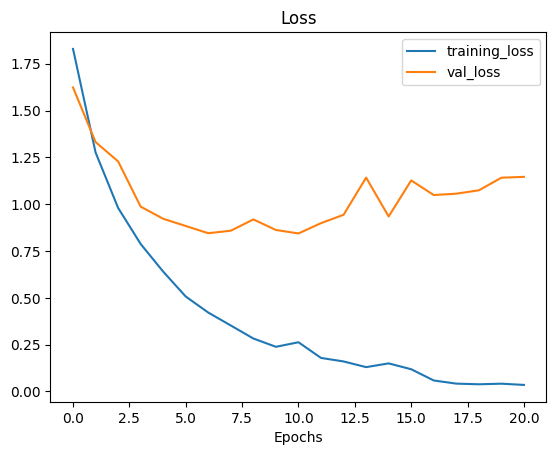

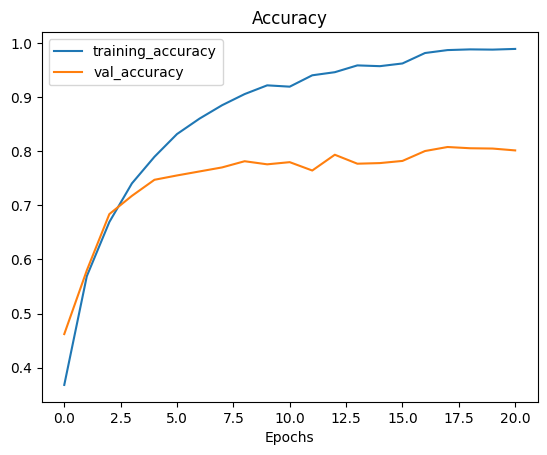

In [48]:
plot_loss_curves(history2)

Still some pretty significatn overfitting, this tells me we may need to make a less dense model and try to extract more general features

In [49]:
input_shape = X_train[0].shape
input_layer = Input(shape=input_shape)
x = Conv2D(32, (3,3), activation="relu")(input_layer)
x = MaxPooling2D(2)(x)
x = Conv2D(64, (3,3), activation="relu")(x)
x = MaxPooling2D(2)(x)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
ouput_layer = Dense(len(classes), activation="softmax")(x)
model3 = Model(input_layer, ouput_layer)

In [51]:
model3.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [52]:
stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience = 10,
    restore_best_weights=True
)

checkpoint_path = "model_checkpoints/model3.model.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    save_best_only = True
)

learning_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    min_lr = 0.000001
)

history3 = model3.fit(X_train,
                      y_train,
                      epochs=100,
                      validation_data=(X_test, y_test),
                      callbacks=[create_tensorboard_callback(dir_name="tensorboard_histories",
                                                             experiment_name="model_3"),
                                 learning_callback,
                                 stop_callback,
                                 checkpoint_callback])

Saving TensorBoard log files to: tensorboard_histories/model_3/20240610-150205
Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.3432 - loss: 2.0664 - val_accuracy: 0.5655 - val_loss: 1.4077 - learning_rate: 0.0010
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6148 - loss: 1.1317 - val_accuracy: 0.6491 - val_loss: 1.1913 - learning_rate: 0.0010
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7342 - loss: 0.7955 - val_accuracy: 0.6863 - val_loss: 1.1342 - learning_rate: 0.0010
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.8021 - loss: 0.6112 - val_accuracy: 0.6898 - val_loss: 1.3914 - learning_rate: 0.0010
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8278 - loss: 0.5203 - val_accuracy: 0.7058 - val_loss: 1.3963 - learning_rate: 0.0010
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8590 - loss: 0.4549 - val_accuracy: 0.7310 - val_loss: 1.5068 - learning_rate: 0.00

In [53]:
model3.evaluate(X_test, y_test)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6736 - loss: 1.1335


[1.1342154741287231, 0.6863194108009338]

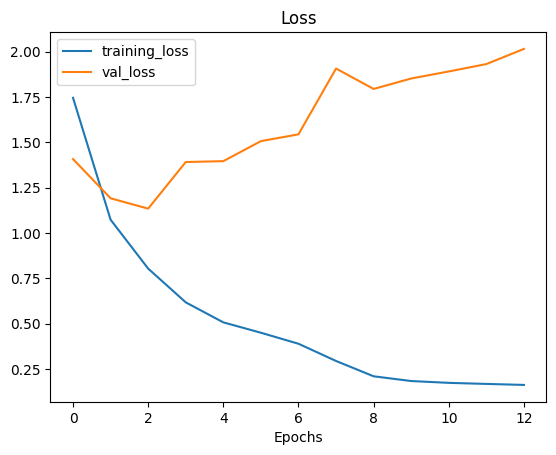

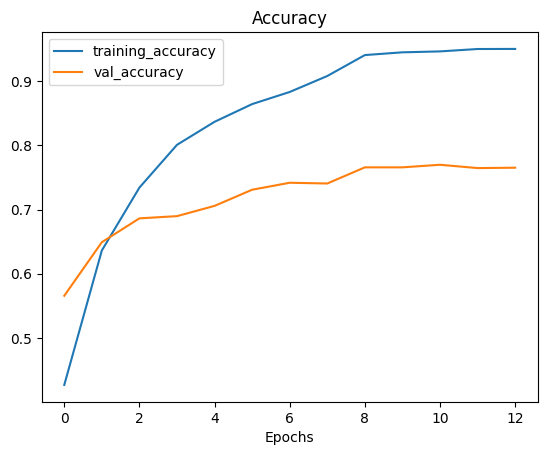

In [54]:
plot_loss_curves(history3)

Still pretty bad, lets see if batch size helps

In [57]:
input_shape = X_train[0].shape
input_layer = Input(shape=input_shape)
x = Conv2D(32, (3,3), activation="relu")(input_layer)
x = MaxPooling2D(2)(x)
x = Conv2D(64, (3,3), activation="relu")(x)
x = MaxPooling2D(2)(x)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
ouput_layer = Dense(len(classes), activation="softmax")(x)
model4 = Model(input_layer, ouput_layer)

model4.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience = 10,
    restore_best_weights=True
)

checkpoint_path = "model_checkpoints/model4.model.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    save_best_only = True
)

learning_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    min_lr = 0.000001
)

history4 = model4.fit(X_train,
                      y_train,
                      epochs=100,
                      batch_size=32,
                      validation_data=(X_test, y_test),
                      callbacks=[create_tensorboard_callback(dir_name="tensorboard_histories",
                                                             experiment_name="model_4"),
                                 learning_callback,
                                 stop_callback,
                                 checkpoint_callback])




Saving TensorBoard log files to: tensorboard_histories/model_4/20240610-150503
Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.3005 - loss: 2.2934 - val_accuracy: 0.5152 - val_loss: 1.4531 - learning_rate: 0.0010
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5853 - loss: 1.1897 - val_accuracy: 0.6079 - val_loss: 1.2916 - learning_rate: 0.0010
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7006 - loss: 0.8977 - val_accuracy: 0.6909 - val_loss: 1.2535 - learning_rate: 0.0010
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7698 - loss: 0.6785 - val_accuracy: 0.7023 - val_loss: 1.3535 - learning_rate: 0.0010
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8155 - loss: 0.5770 - val_accuracy: 0.6989 - val_loss: 1.4163 - learning_rate: 0.0010
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8443 - loss: 0.4962 - val_accuracy: 0.6669 - val_loss: 1.7736 - learning_rate: 0.00

In [58]:
model4.evaluate(X_test, y_test)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6867 - loss: 1.3850


[1.2535450458526611, 0.6908986568450928]

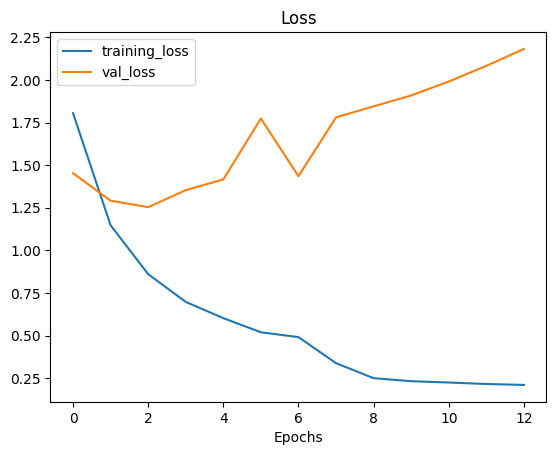

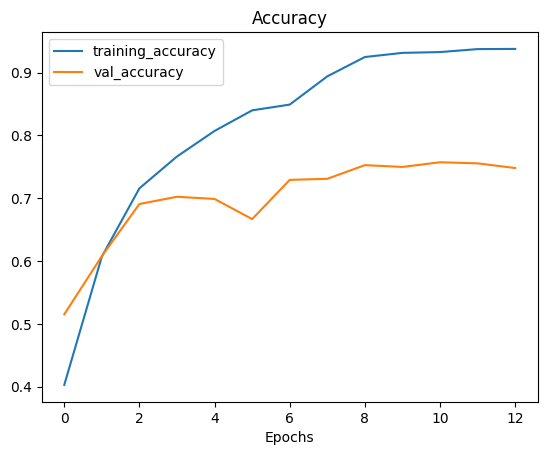

In [59]:
plot_loss_curves(history4)

In [60]:
input_shape = X_train[0].shape
input_layer = Input(shape=input_shape)
x = Conv2D(32, (3,3), activation="relu")(input_layer)
x = MaxPooling2D(2)(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = Conv2D(64, (3,3), activation="relu")(x)
x = MaxPooling2D(2)(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
ouput_layer = Dense(len(classes), activation="softmax")(x)
model5 = Model(input_layer, ouput_layer)

model5.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience = 10,
    restore_best_weights=True
)

checkpoint_path = "model_checkpoints/model5.model.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    save_best_only = True
)

learning_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    min_lr = 0.000001
)

history5 = model5.fit(X_train,
                      y_train,
                      epochs=100,
                      batch_size=32,
                      validation_data=(X_test, y_test),
                      callbacks=[create_tensorboard_callback(dir_name="tensorboard_histories",
                                                             experiment_name="model_5"),
                                 learning_callback,
                                 stop_callback,
                                 checkpoint_callback])




Saving TensorBoard log files to: tensorboard_histories/model_5/20240610-151253
Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.2811 - loss: 2.8796 - val_accuracy: 0.4070 - val_loss: 1.7091 - learning_rate: 0.0010
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5216 - loss: 1.4251 - val_accuracy: 0.5197 - val_loss: 1.4305 - learning_rate: 0.0010
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.6067 - loss: 1.1406 - val_accuracy: 0.5999 - val_loss: 1.2874 - learning_rate: 0.0010
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.6735 - loss: 0.9545 - val_accuracy: 0.6485 - val_loss: 1.3215 - learning_rate: 0.0010
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7328 - loss: 0.8208 - val_accuracy: 0.6537 - val_loss: 1.2520 - learning_rate: 0.0010
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7537 - loss: 0.7550 - val_accuracy: 0.6760 - val_loss: 1.2711 - learning_rate: 0.00

In [61]:
model5.evaluate(X_test, y_test)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7289 - loss: 1.3231


[1.1789872646331787, 0.7286777496337891]

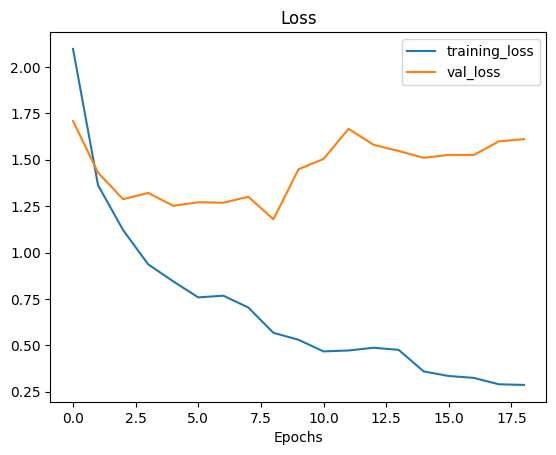

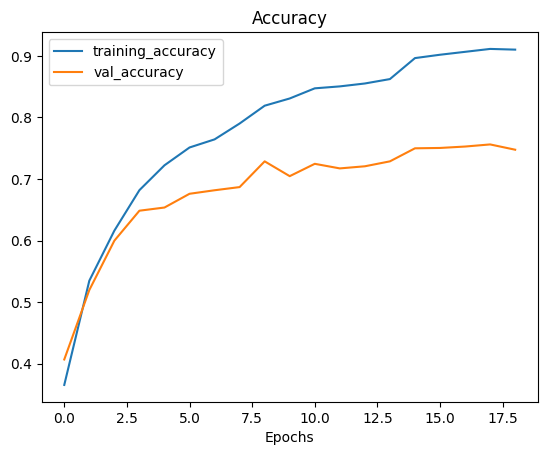

In [62]:
plot_loss_curves(history5)

Still not performing up to standards, could be the quality of data and the unpredicatble aspects of noise itself, so lets try some more augmentation techniques.

In [90]:
import random
def add_noise(data, noise_factor=0.005):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    return augmented_data

def time_shift(data, shift_max=0.2):
    shift = np.random.randint(int(len(data) * shift_max))
    return np.roll(data, shift)

def change_volume(data, vol_range=(0.8, 1.2)):
    factor = np.random.uniform(vol_range[0], vol_range[1])
    return data * factor

def apply_augmentations(audio_data, sampling_rate, rate, target_duration, apply=True):
    if (random.random() < rate) and apply:
        audio_data = librosa.effects.time_stretch(audio_data, rate=np.random.uniform(0.8, 1.2))
        apply = False
    
    if (random.random() < rate) and apply:
        audio_data = librosa.effects.pitch_shift(y=audio_data, sr=sampling_rate, n_steps=np.random.randint(-5, 5))
        apply = False
    
    if (random.random() < rate) and apply:
        audio_data = add_noise(audio_data, noise_factor=0.005)
        apply = False
    
    if (random.random() < rate) and apply:
        audio_data = time_shift(audio_data, shift_max=0.2)
        apply = False
    
    if (random.random() < rate) and apply:
        audio_data = change_volume(audio_data, vol_range=(0.8, 1.2))
        apply = False
    
    # Ensure the duration of the augmented data matches the target duration
    target_length = int(sampling_rate * target_duration)
    if len(audio_data) > target_length:
        audio_data = audio_data[:target_length]
    elif len(audio_data) < target_length:
        audio_data = librosa.util.pad_center(data=audio_data, size=target_length, axis=0)
    
    return audio_data

In [91]:
def load_and_preprocess_data(data_dir, classes, target_shape=(128, 128), augment=True, max_augmentations=2):
    data=[]
    labels=[]
    target_sr = 44100
    target_duration = 4  # Duration of each spectrogram in seconds

    for i, classname in enumerate(classes):
        class_dir = os.path.join(data_dir, str(classname))
        for filename in os.listdir(class_dir):
            if filename.endswith(".wav"):
                filepath = os.path.join(class_dir, filename)
                audio_data, sampling_rate = librosa.load(filepath, sr=None)
                audio_data = librosa.resample(audio_data, orig_sr=sampling_rate, target_sr=target_sr)

                if (audio_data.shape[0] > ((target_sr//1000) * 4000)):
                    audio_data = audio_data[:((target_sr//1000) * 4000)]
                elif (audio_data.shape[0] < ((target_sr//1000) * 4000)):
                    audio_data = librosa.util.pad_center(data=audio_data, size=(target_sr//1000) * 4000, axis=0)
                
                if augment:
                    # Apply augmentations to the whole spectrogram
                    for _ in range(max_augmentations):
                        audio_data_augmented = apply_augmentations(audio_data, target_sr, rate=0.3, target_duration=target_duration)
                        mel_spec = librosa.feature.melspectrogram(y=audio_data_augmented, sr=target_sr, n_mels=64, n_fft=1024, hop_length=None)
                        mel_spec = tf.image.resize(np.expand_dims(mel_spec, axis=-1), target_shape)
                        data.append(mel_spec)
                        labels.append(i)
                
                # Add the original spectrogram without augmentation
                mel_spec_original = librosa.feature.melspectrogram(y=audio_data, sr=target_sr, n_mels=64, n_fft=1024, hop_length=None)
                mel_spec_original = tf.image.resize(np.expand_dims(mel_spec_original, axis=-1), target_shape)
                data.append(mel_spec_original)
                labels.append(i)
                
    return np.array(data), np.array(labels)

In [92]:

data, labels = load_and_preprocess_data(data_dir, classes)
labels = tf.keras.utils.to_categorical(labels, num_classes=len(classes))
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, labels, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = model_selection.train_test_split(data, labels, test_size=0.2, random_state=42)



In [94]:
print(len(X_test), len(X_train), len(y_test), len(y_train))

5240 20956 5240 20956
0.7999694609864101


In [95]:
input_shape = X_train[0].shape
input_layer = Input(shape=input_shape)
x = Conv2D(32, (3,3), activation="relu")(input_layer)
x = MaxPooling2D(2)(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = Conv2D(64, (3,3), activation="relu")(x)
x = MaxPooling2D(2)(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
ouput_layer = Dense(len(classes), activation="softmax")(x)
model6 = Model(input_layer, ouput_layer)

model6.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience = 10,
    restore_best_weights=True
)

checkpoint_path = "model_checkpoints/model6.model.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    save_best_only = True
)

learning_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    min_lr = 0.000001
)

history6 = model6.fit(X_train,
                      y_train,
                      epochs=100,
                      batch_size=32,
                      validation_data=(X_test, y_test),
                      callbacks=[create_tensorboard_callback(dir_name="tensorboard_histories",
                                                             experiment_name="model_6"),
                                 learning_callback,
                                 stop_callback,
                                 checkpoint_callback])




Saving TensorBoard log files to: tensorboard_histories/model_6/20240610-161803
Epoch 1/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - accuracy: 0.3916 - loss: 1.9540 - val_accuracy: 0.6279 - val_loss: 1.1460 - learning_rate: 0.0010
Epoch 2/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.6530 - loss: 1.0243 - val_accuracy: 0.7143 - val_loss: 0.9054 - learning_rate: 0.0010
Epoch 3/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.7423 - loss: 0.7897 - val_accuracy: 0.7061 - val_loss: 0.9017 - learning_rate: 0.0010
Epoch 4/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.7791 - loss: 0.6640 - val_accuracy: 0.7555 - val_loss: 0.7924 - learning_rate: 0.0010
Epoch 5/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.8113 - loss: 0.5709 - val_accuracy: 0.7714 - val_loss: 0.7726 - learning_rate: 0.0010
Epoch 6/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.8412 - loss: 0.5063 - val_accuracy: 0.8029 - val_loss: 0.8775 - learning_rate

In [96]:
full_augmentation_first_model = model6.evaluate(X_test, y_test)
full_augmentation_first_model

164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8551 - loss: 0.7363


[0.6792992353439331, 0.8545801639556885]

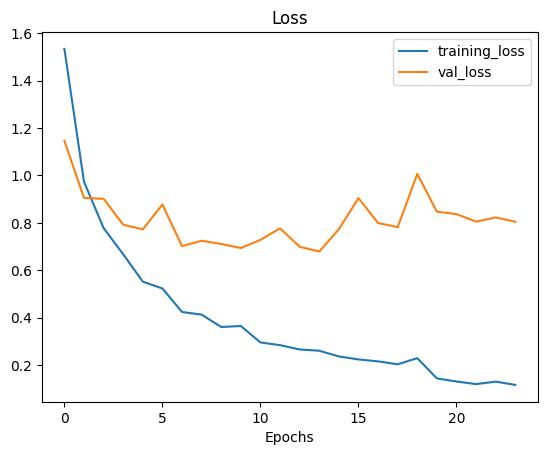

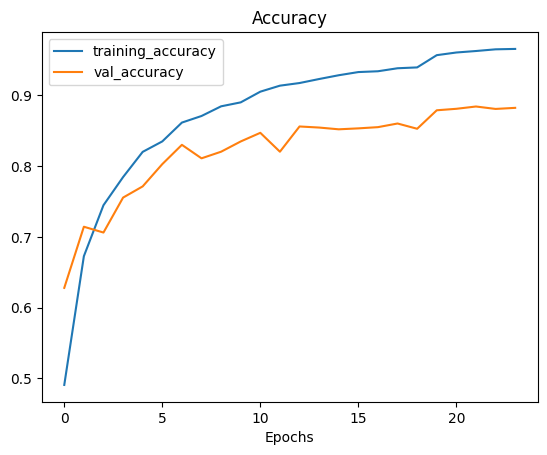

In [97]:
plot_loss_curves(history6)

We can see that some overfitting is still occuring post augmentation, however this is clearly a better result as we reach 85% testing data success and the overfitting is less sever, lets try a different model on this data as well

In [98]:
input_shape = X_train[0].shape
input_layer = Input(shape=input_shape)
x = Conv2D(64, (3,3), activation="relu")(input_layer)
x = tf.keras.layers.Dropout(0.3)(x)
x = Conv2D(32, (3,3), activation = "relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = MaxPooling2D(2)(x)
x = Conv2D(32, (3,3), activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = Conv2D(16, (3,3), activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = MaxPooling2D(2)(x)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
ouput_layer = Dense(len(classes), activation="softmax")(x)
model7 = Model(input_layer, ouput_layer)

model7.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience = 10,
    restore_best_weights=True
)

checkpoint_path = "model_checkpoints/model7.model.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    save_best_only = True
)

learning_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    min_lr = 0.000001
)

history7 = model7.fit(X_train,
                      y_train,
                      epochs=100,
                      batch_size=32,
                      validation_data=(X_test, y_test),
                      callbacks=[create_tensorboard_callback(dir_name="tensorboard_histories",
                                                             experiment_name="model_7"),
                                 learning_callback,
                                 stop_callback,
                                 checkpoint_callback])

Saving TensorBoard log files to: tensorboard_histories/model_7/20240610-163015
Epoch 1/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.4100 - loss: 1.7242 - val_accuracy: 0.6685 - val_loss: 1.1965 - learning_rate: 0.0010
Epoch 2/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 36s 54ms/step - accuracy: 0.7293 - loss: 0.8282 - val_accuracy: 0.7718 - val_loss: 0.7982 - learning_rate: 0.0010
Epoch 3/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 35s 54ms/step - accuracy: 0.8173 - loss: 0.5393 - val_accuracy: 0.7979 - val_loss: 0.6603 - learning_rate: 0.0010
Epoch 4/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 35s 53ms/step - accuracy: 0.8780 - loss: 0.3562 - val_accuracy: 0.8246 - val_loss: 0.5981 - learning_rate: 0.0010
Epoch 5/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 35s 53ms/step - accuracy: 0.9118 - loss: 0.2796 - val_accuracy: 0.8647 - val_loss: 0.4646 - learning_rate: 0.0010
Epoch 6/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 35s 54ms/step - accuracy: 0.9326 - loss: 0.2133 - val_accuracy: 0.8635 - val_loss: 0.4623 - learning_rate

In [99]:
model_7_accuracy = model7.evaluate(X_test, y_test)
model_7_accuracy

164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9166 - loss: 0.3828


[0.35982832312583923, 0.9152671694755554]

That is a VERY good model, lets save this to disk so that we can use it without completely retraining

In [100]:
model7.save("sound_project_CNN.keras")

Lets test loading and running on this saved model

In [101]:
loaded_model = tf.keras.models.load_model("sound_project_CNN.keras")

In [102]:
loaded_evals = loaded_model.evaluate(X_test, y_test)
loaded_evals

164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9166 - loss: 0.3828


[0.35982832312583923, 0.9152671694755554]

In [103]:
print(np.isclose(model_7_accuracy, loaded_evals))

[ True  True]


Yep! We can save and load the model just fine

In [108]:
def test_audio_file(file_path, model):
    target_sr = 44100
    target_shape = (128, 128)
    audio_data, sample_rate = librosa.load(file_path, sr=None)
    audio_data = librosa.resample(audio_data, orig_sr=sample_rate, target_sr=target_sr)

    if (audio_data.shape[0] > ((target_sr//1000) * 4000)):
        audio_data = audio_data[:((target_sr//1000) * 4000)]
    elif (audio_data.shape[0] < ((target_sr//1000) * 4000)):
        audio_data = librosa.util.pad_center(data=audio_data, size=(target_sr//1000) * 4000, axis=0)
    
    mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=target_sr, n_mels=64, n_fft=1024, hop_length=None)
    mel_spec = tf.image.resize(np.expand_dims(mel_spec, axis=-1), target_shape)
    mel_spec = tf.reshape(mel_spec, (1,) + target_shape + (1,))

    predictions = model.predict(mel_spec)
    class_probs = predictions[0]
    predicted_class_idx = np.argmax(class_probs)

    for i, class_label in enumerate(classes):
        prob = class_probs[i]
        print(f"Class {class_label} has a probability of {prob:.2f} to be the sound input\n")
    pred_class = classes[predicted_class_idx]
    acc = class_probs[predicted_class_idx]
    print(f"The sound is classified as {pred_class} with a probability of {acc}\n")

In [109]:
test_audio_file("two_dogs_barking_9LS.wav", loaded_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
Class dog_bark has a probability of 1.00 to be the sound input

Class children_playing has a probability of 0.00 to be the sound input

Class car_horn has a probability of 0.00 to be the sound input

Class air_conditioner has a probability of 0.00 to be the sound input

Class street_music has a probability of 0.00 to be the sound input

Class gun_shot has a probability of 0.00 to be the sound input

Class siren has a probability of 0.00 to be the sound input

Class engine_idling has a probability of 0.00 to be the sound input

Class jackhammer has a probability of 0.00 to be the sound input

Class drilling has a probability of 0.00 to be the sound input

The sound is classified as dog_bark with a probability of 1.0



In [110]:
test_audio_file("air-conditioner-in-car-83788.wav", loaded_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Class dog_bark has a probability of 0.00 to be the sound input

Class children_playing has a probability of 0.00 to be the sound input

Class car_horn has a probability of 0.00 to be the sound input

Class air_conditioner has a probability of 0.59 to be the sound input

Class street_music has a probability of 0.00 to be the sound input

Class gun_shot has a probability of 0.00 to be the sound input

Class siren has a probability of 0.00 to be the sound input

Class engine_idling has a probability of 0.08 to be the sound input

Class jackhammer has a probability of 0.32 to be the sound input

Class drilling has a probability of 0.01 to be the sound input

The sound is classified as air_conditioner with a probability of 0.5852702856063843



In [111]:
test_audio_file("loud-fan-at-rotterdam-blaak-trainstation-22475.wav", loaded_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Class dog_bark has a probability of 0.00 to be the sound input

Class children_playing has a probability of 0.02 to be the sound input

Class car_horn has a probability of 0.00 to be the sound input

Class air_conditioner has a probability of 0.26 to be the sound input

Class street_music has a probability of 0.67 to be the sound input

Class gun_shot has a probability of 0.00 to be the sound input

Class siren has a probability of 0.02 to be the sound input

Class engine_idling has a probability of 0.03 to be the sound input

Class jackhammer has a probability of 0.01 to be the sound input

Class drilling has a probability of 0.00 to be the sound input

The sound is classified as street_music with a probability of 0.6662786602973938



First failure, which makes sense listening to this as it is a higher frequency fan in an outside environment with more overall variables

In [112]:
classes

array(['dog_bark', 'children_playing', 'car_horn', 'air_conditioner',
       'street_music', 'gun_shot', 'siren', 'engine_idling', 'jackhammer',
       'drilling'], dtype=object)

In [113]:
test_audio_file("062790_car-engine-idle-82134.wav", loaded_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Class dog_bark has a probability of 0.00 to be the sound input

Class children_playing has a probability of 0.00 to be the sound input

Class car_horn has a probability of 0.00 to be the sound input

Class air_conditioner has a probability of 0.00 to be the sound input

Class street_music has a probability of 0.00 to be the sound input

Class gun_shot has a probability of 0.00 to be the sound input

Class siren has a probability of 0.00 to be the sound input

Class engine_idling has a probability of 0.02 to be the sound input

Class jackhammer has a probability of 0.98 to be the sound input

Class drilling has a probability of 0.00 to be the sound input

The sound is classified as jackhammer with a probability of 0.9834279417991638



Hmmm, we can see the model fails with some of the low trembling noises

In [114]:
test_audio_file("roadworks-02-69791.wav", loaded_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Class dog_bark has a probability of 0.00 to be the sound input

Class children_playing has a probability of 0.00 to be the sound input

Class car_horn has a probability of 0.00 to be the sound input

Class air_conditioner has a probability of 0.02 to be the sound input

Class street_music has a probability of 0.00 to be the sound input

Class gun_shot has a probability of 0.00 to be the sound input

Class siren has a probability of 0.00 to be the sound input

Class engine_idling has a probability of 0.00 to be the sound input

Class jackhammer has a probability of 0.84 to be the sound input

Class drilling has a probability of 0.14 to be the sound input

The sound is classified as jackhammer with a probability of 0.8406360745429993



Did good on the jackhammer sound though

In [115]:
test_audio_file("car-horn-90973.wav", loaded_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Class dog_bark has a probability of 0.00 to be the sound input

Class children_playing has a probability of 0.00 to be the sound input

Class car_horn has a probability of 0.96 to be the sound input

Class air_conditioner has a probability of 0.00 to be the sound input

Class street_music has a probability of 0.00 to be the sound input

Class gun_shot has a probability of 0.00 to be the sound input

Class siren has a probability of 0.00 to be the sound input

Class engine_idling has a probability of 0.00 to be the sound input

Class jackhammer has a probability of 0.00 to be the sound input

Class drilling has a probability of 0.04 to be the sound input

The sound is classified as car_horn with a probability of 0.9573096632957458



In [116]:
test_audio_file("children-playing-30728.wav", loaded_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class dog_bark has a probability of 0.00 to be the sound input

Class children_playing has a probability of 1.00 to be the sound input

Class car_horn has a probability of 0.00 to be the sound input

Class air_conditioner has a probability of 0.00 to be the sound input

Class street_music has a probability of 0.00 to be the sound input

Class gun_shot has a probability of 0.00 to be the sound input

Class siren has a probability of 0.00 to be the sound input

Class engine_idling has a probability of 0.00 to be the sound input

Class jackhammer has a probability of 0.00 to be the sound input

Class drilling has a probability of 0.00 to be the sound input

The sound is classified as children_playing with a probability of 0.9953268766403198



In [118]:
test_audio_file("electric-drill-154590.wav", loaded_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Class dog_bark has a probability of 0.00 to be the sound input

Class children_playing has a probability of 0.00 to be the sound input

Class car_horn has a probability of 0.00 to be the sound input

Class air_conditioner has a probability of 0.00 to be the sound input

Class street_music has a probability of 0.00 to be the sound input

Class gun_shot has a probability of 0.00 to be the sound input

Class siren has a probability of 0.00 to be the sound input

Class engine_idling has a probability of 0.00 to be the sound input

Class jackhammer has a probability of 0.00 to be the sound input

Class drilling has a probability of 1.00 to be the sound input

The sound is classified as drilling with a probability of 1.0

